In [2]:
# Establece las librerias del sistema
# Manejo de datos
import pandas as pd
import numpy as np
# Maejo de directorios y archivos
import os
import glob
# Librerias de pronotiscos
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.seasonal import seasonal_decompose
# Advertencias del sistema
import warnings
warnings.filterwarnings('ignore')



# Funciones internas
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:

categoria =  'CarnicosData'
vista = categoria + "-ini"
path = ( categoria +  '.xlsx')
xl = pd.ExcelFile(path)
fecha_inicio = '2020-03-02'
pproyeccion = 72
print(xl.sheet_names)


df0 = xl.parse('dt')
df1= pd.DataFrame(df0)


dir_actual = os.getcwd()

Pais = "Carnico-Etapa1"

path = os.path.join(dir_actual, Pais)

try:
  os.mkdir(path)
except:
  print("An exception occurred")


['Hoja2', 'Hoja3', 'E3', 'e2', 'e1', 'dt2', 'dt', 'dt1']
An exception occurred


In [4]:
e1 = pd.pivot_table(df1, values='Cantidad', index=['Fecha'],columns=['Linea'], aggfunc=np.sum)
tpath = os.path.join(path,"Lineas.xlsx")
e1.to_excel(tpath)
print(e1)


Linea       Chorizo y Variedades    Salchicha
Fecha                                        
2020-03-02            282166.047  1079965.096
2020-03-09            299151.658  1142863.117
2020-03-16            367175.023  1381084.385
2020-03-23            317525.847  1306365.189
2020-03-30            315382.136  1366658.005
...                          ...          ...
2023-01-09            432397.768  1509996.229
2023-01-16            324708.342  1323359.776
2023-01-23            360031.838  1464297.433
2023-01-30            354737.917  1459795.078
2023-02-06            323462.047  1366814.121

[155 rows x 2 columns]


In [5]:
dfc = df1[(df1.Linea == 'Chorizo y Variedades')]
dfs = df1[(df1.Linea == 'Salchicha')]
e2c = pd.pivot_table(dfc, values='Cantidad', index=['Fecha'],columns=['Centro Distribución'], aggfunc=np.sum, margins=True,margins_name="Total")
e2s = pd.pivot_table(dfs, values='Cantidad', index=['Fecha'],columns=['Centro Distribución'], aggfunc=np.sum,margins=True,margins_name="Total")
#Copia el dataframe para rellenar con menor sesgo posteriormente
#Chorizos
e2cn = e2c.copy(deep=True)
Ntotalc =e2c["Total"]/e2c["Total"].loc["Total"]
e2cn.iloc[0:155] = e2c.loc["Total"]
e2c["NTotal"] = Ntotalc
e2cn = e2cn.multiply(e2c["NTotal"], axis = "index")
#Salchichas
e2sn = e2s.copy(deep=True)
Ntotals =e2s["Total"]/e2s["Total"].loc["Total"]
e2sn.iloc[0:155] = e2s.loc["Total"]
e2s["NTotal"] = Ntotals
e2sn = e2sn.multiply(e2s["NTotal"], axis = "index")

spath = os.path.join(path,"CenDis_Salchicha_Procesado.xlsx")
cpath = os.path.join(path,"CenDis_Chorizo_Procesado.xlsx")
#Rellena dt con los datos de menor sesgo
e2c = e2c.fillna(e2cn)
e2s= e2s.fillna(e2sn)


e2c.to_excel(cpath)
e2s.to_excel(spath)

In [6]:
cdlist = df1["Centro Distribución"].unique()
pivotlistc = {}
pivotlists = {}
pivotlistc2 = {}
pivotlists2 = {}
#Crea las tablas pivote de material por centro de distribucion
for Cd in cdlist:
    dfccd = dfc[(dfc["Centro Distribución"] == Cd)]
    dfscd = dfs[(dfs["Centro Distribución"] == Cd)]

    e3c = pd.pivot_table(dfccd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum)
    e3s = pd.pivot_table(dfscd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum)
    e3c2 = pd.pivot_table(dfccd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum, margins=True,margins_name="Total")
    e3s2 = pd.pivot_table(dfscd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum, margins=True,margins_name="Total")
    pivotlistc[Cd]=(e3c)
    pivotlists[Cd]=(e3s)
    pivotlistc2[Cd]=(e3c2)
    pivotlists2[Cd]=(e3s2)
print(pivotlists["NN18"])


Codmat      M1000031  M1000814  M1000820  M1000821  M1000833  M1000840  \
Fecha                                                                    
2020-03-02   701.195   486.851  1656.609  1134.815   881.475    83.545   
2020-03-09   834.006   311.220  2074.055  1525.621   980.146    95.945   
2020-03-16   743.755  1717.170  3135.832  1083.117   856.982    81.995   
2020-03-23   675.452   653.380  2788.510   286.701  1306.517    28.211   
2020-03-30   833.723   673.400  3075.938   425.585  1296.165    22.940   
...              ...       ...       ...       ...       ...       ...   
2023-01-09  2526.750   285.000  5153.000  2503.000  1617.500   287.500   
2023-01-16  2251.469   348.000  4564.000  2492.875  1360.563   343.000   
2023-01-23  2048.250   510.000  5125.500  2522.547  1317.500   250.000   
2023-01-30  1999.750   607.000  5780.000  2547.115  1377.500   372.500   
2023-02-06  1765.000   395.000  4878.500  2467.067  1034.500   297.500   

Codmat      M1000845  M1000849   M100

In [7]:
sframe = pd.DataFrame()
cframe = pd.DataFrame()
#Dataframe de las categorias
cframe.index = ['A','B','C']
sframe.index = ['A','B','C']
dfproyeccioness = {}
dfproyeccionesc = {}
matstoprojects = {}
matstoprojectc = {}

def categoria(x):
    if x == 100:
        return 'A'
    elif x >= 90:
        return 'B'
    elif x < 90 or x is None:
        return 'C'

def matrizsesgo(x2,rows):
    xn = x2.copy(deep=True)

    Ntotalc =x2["Total"]/x2["Total"].loc["Total"]
    xn.iloc[0:rows] = xn.loc["Total"]
    x2["NTotal"] = Ntotalc
    xcn = xn.multiply(x2["NTotal"], axis = "index")
    return xcn

for cd in cdlist:
    df2 = pivotlistc[cd]
    df2t = pivotlistc2[cd]
    rowsch = df2t.shape[0]
    mirrorc = matrizsesgo(df2t,rowsch)
    #Cuenta los datos no vacios, convierte a porcentaje y categoriza
    df3 = df2.count()
    df3 = df3.divide(155).multiply(100)
    df3a= df3.apply(categoria)
    aprovedc = df3a[df3a == "A"]
    aprovedc = list(aprovedc.index.values)
    matstoprojectc[cd] = aprovedc
    df3a=df3a.value_counts()
    cframe[cd] = df3a

    df4 = pivotlists[cd]
    df4t = pivotlists2[cd]
    rowssal = df4t.shape[0]
    mirrors = matrizsesgo(df4t,rowssal)
    df5 = df4.count()
    df5 = df5.divide(155).multiply(100)
    df5a= df5.apply(categoria)
    aproveds = df5a[df5a == "A"]
    aproveds = list(aproveds.index.values)
    matstoprojects[cd] = aproveds
    df5a=df5a.value_counts()
    sframe[cd] = df5a

    df2.fillna(mirrorc, inplace=True)
    df4.fillna(mirrors, inplace=True)
    dfproyeccionesc[cd] = df2
    dfproyeccioness[cd] = df4

spath = os.path.join(path,"Reporte_Salchichas.xlsx")
cpath = os.path.join(path,"Reporte_Chorizos.xlsx")
#Guarda el reporte en excel
print(sframe)
print(cframe)
sframe.to_excel(spath, index_label="Periodo")
cframe.to_excel(cpath, index_label="Periodo")
print("Termino")

   NN13  NN14  NN18  NN20  NN21  NN24  NN27  NN29  NN53  NN97  NNB1  NNB2  \
A    30    27    30    24    27    22    16    25    24    25   NaN    23   
B     5     8     5    10     8    12    15     7     8    10  21.0     6   
C     7     7     9     6     5     8     7     8     4     4  10.0     8   

   NNB8  
A    25  
B     8  
C     5  
   NN13  NN14  NN18  NN20  NN21  NN24  NN27  NN29  NN53  NN97  NNB1  NNB2  \
A     2     2     3   NaN     2    11   NaN     3     1     1     1   NaN   
B    18    18    12  13.0    11     2  13.0    10    12    19    11  13.0   
C     3     3     2   2.0     2     2   2.0     3     2     3     1   2.0   

   NNB8  
A   NaN  
B  14.0  
C   2.0  
Termino


['M1000497', 'M1000794', 'M1000820', 'M1000821', 'M1000833', 'M1000845', 'M1000849', 'M1000852', 'M1000853', 'M1001014', 'M1012343', 'M1012346', 'M1012347', 'M1015294', 'M1015605', 'M1017925', 'M1019732', 'M1019943', 'M1019944', 'M1027817', 'M1029973', 'M1031533', 'M1035365', 'M1042513', 'M1043327', 'M1043443', 'M1043643', 'M1044284', 'M1045788', 'M1046292']
Dataframe
Fecha
2020-03-02    21750.008
2020-03-09    26246.252
2020-03-16    24196.504
2020-03-23    21891.501
2020-03-30    19066.667
                ...    
2023-01-09    12985.943
2023-01-16    10244.000
2023-01-23     8667.000
2023-01-30     9334.000
2023-02-06    15545.000
Name: M1000116, Length: 155, dtype: float64
MAPE M1000116 = 13.046720576827509
Fecha
2020-03-02     7975.000
2020-03-09     8082.000
2020-03-16     6577.000
2020-03-23     7078.000
2020-03-30     6058.000
                ...    
2023-01-09    13634.833
2023-01-16    11026.000
2023-01-23    13731.000
2023-01-30    12963.000
2023-02-06    12339.000
Name: M103

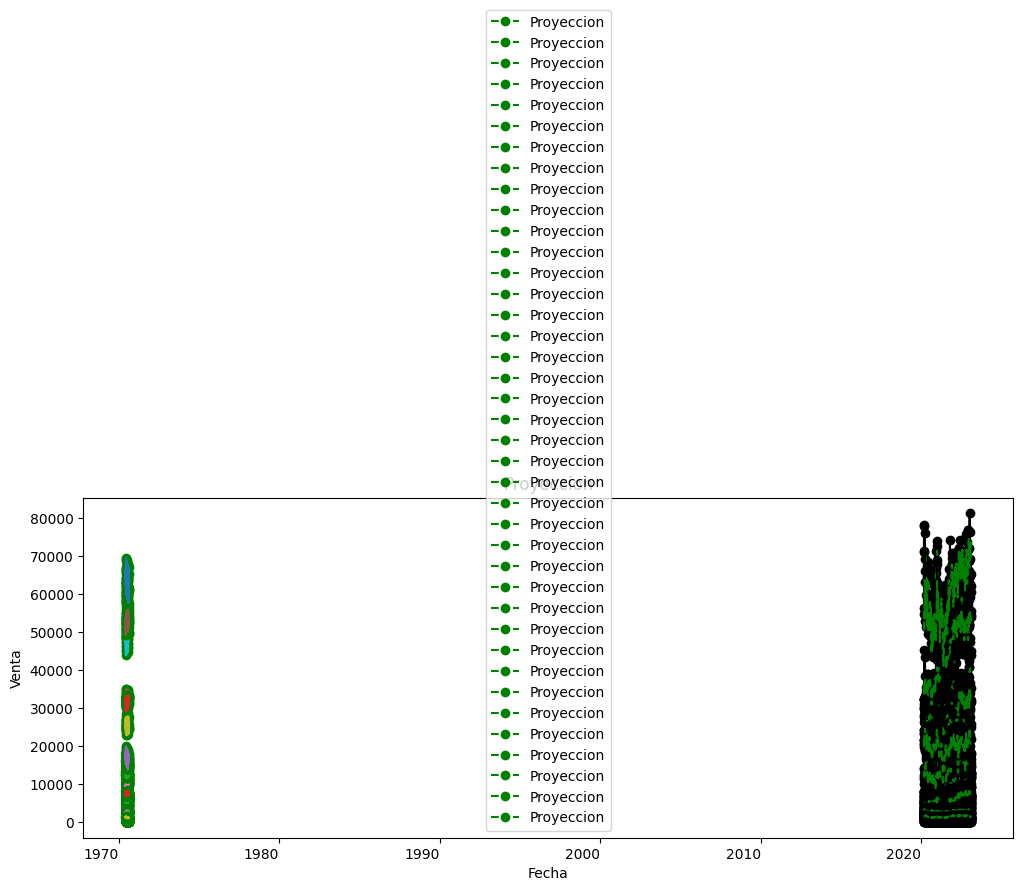

In [12]:
def Proyeccion(cd,columnName,df3,periodos,ptrend,pseasonal,pdamped,puse,tipo):

        df10 = df3[columnName]
        #df10.plot(figsize=(12, 5))
        # Analisis de descomposicion
        #components = seasonal_decompose(df10, period=8)
        #components.plot()
        # Proyeccion
        fit1 = ExponentialSmoothing(df10, seasonal_periods=periodos,trend=ptrend,seasonal=pseasonal,damped_trend=pdamped,use_boxcox=puse,initialization_method="estimated",missing="drop").fit()
        #print(fit1.summary())
        # Calcula el intervalo de confianza al 95% y lo salva
        xhat = fit1.forecast(steps= pproyeccion)
        z = 1.96
        sse = fit1.sse
        predint_xminus = xhat - z * np.sqrt(sse/len(df10))
        predint_xplus  = xhat + z * np.sqrt(sse/len(df10))

        df = [predint_xminus,predint_xplus]
        df = pd.DataFrame(df)
        df = df.transpose()
        col0 =cd+ columnName + "_minimo"
        col1 =cd+ columnName + "_maximo"

        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)

        # Salva los intervalos

        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+vista + '-py_intervalo_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        df.to_excel(dirPath, index_label="Periodo")


        # Intervalo de confianza por simulacion
        simulations = fit1.simulate(pproyeccion, repetitions=1, error="add", random_errors=None)
        ax = df10.plot(figsize=(12, 5),marker="o",color="black",title="Proyeccion",)
        ax.set_ylabel("Venta")
        ax.set_xlabel("Periodo")
        fit1.fittedvalues.plot(ax=ax, style="--", color="green")
        fit1.forecast(steps=pproyeccion).rename("Proyeccion").plot(ax=ax, style="--", marker="o", color="green", legend=True )


        # Grafica la serie de Ajuste y la añade a fit1
        df6 = fit1.forecast(pproyeccion)
        df6.plot()
        df7 = fit1.predict(0)

        df8 = [df7,df6]

        #df1 = (df0[[columnName]])

        df = pd.DataFrame(df8)
        df = df.transpose()
        col0 = columnName + "_ajuste"
        col1 = columnName + "_proyeccion"

        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)
        # Salva la proyeccion normal
        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+ vista + '-py_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        df.to_excel(dirPath, index_label="Periodo")

        # Calcula el Error por medio del MAPE
        df99 = [df7]
        yy = pd.DataFrame(df99)
        yy = yy.transpose()
        xx = pd.DataFrame(df10)
        print("MAPE " + columnName + " = " + str(mape(xx,yy)))

def Procesamiento(df,cd,tipo):
    for (columnName, columnData) in df.items():
        #print('Column Name : ', columnName)
        #print('Column Contents : ', columnData.values)
        # Parametros personalizados
        ptrend = 'add'
        pseasonal = 'add'
        pdamped = True
        puse = True
        periodos = 24

        if (columnName != 'Periodo') :
           try:
                Proyeccion(cd,columnName,df,periodos,ptrend,pseasonal,pdamped,puse,tipo)
           except:
                Proyeccion(cd,columnName,df,4,ptrend,pseasonal,pdamped,puse,tipo)


for cd in cdlist:

    totalcds = e2s[cd]
    totalcds = totalcds.drop("Total")
    totalcdc = e2c[cd]
    totalcdc = totalcdc.drop("Total")

    print(matstoprojects[cd])
    print("Dataframe")

    dfps2 = dfproyeccioness[cd]
    dfps2 = dfps2.loc[:, dfps2.columns.isin(matstoprojects[cd])]
    dfps2['Total'] = totalcds

    #Procesamiento(dfps2,cd,"Salchicha")

    dfpc2 = dfproyeccionesc[cd]
    dfpc2 = dfpc2.loc[:, dfpc2.columns.isin(matstoprojectc[cd])]
    dfpc2['Total'] = totalcdc
    Procesamiento(dfpc2,cd,"Chorizo")